# LangGraph Agent Simulation

- Author: [Youngjun Cho](https://github.com/choincnp)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

...

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [...](#...)

### References

- [LangChain](https://blog.langchain.dev/)
- [...](...)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
        "langgraph"
        "langchain-teddynote"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "",  # set the project name same as the title
        }
    )

## Agent Conversation Simulation (Customer Support Scenario)

When building a chatbot, such as a customer support assistant, evaluating its performance can be challenging. Manually interacting with the chatbot for each code change is time-consuming.

One way to make the evaluation process easier and more reproducible is simulating user interactions.

Using LangGraph, setting this up is straightforward.

Below is an example of creating a "Simulated User" to simulate conversations.

![](./assets/01-langgraph-agent-simulation.png)

## Define State

In [4]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

# Define the state
class State(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation messages between user and agent

## Define Roles: Agent and Customer
### Agent Role
Define the chatbot role acting as the agent in the simulation.

[ **Note** ]  
- The implementation inside `call_chatbot` is configurable, and the internal model used can be replaced with an Agent.
- `call_chatbot` takes user messages as input and generates responses as a customer support agent.

*고객 지원 시나리오에서의 대화 응답 생성에 활용될 수 있습니다.*

In [5]:
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser

def call_chatbot(messages: List[BaseMessage]) -> dict:
    # LangChain ChatOpenAI model can be replaced with an Agent
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})

`call_chatbot` processes user inputs and generates chatbot responses.

In [6]:
call_chatbot([("user", "Hello?")])

'안녕하세요! 무엇을 도와드릴까요?'

## Simulated User Role
Define the role of the simulated customer. This simulates conversations in a customer support scenario.

The system prompt sets up the interaction between the customer and the support agent, with detailed user instructions defining the scenario.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_scenario(name: str, instructions: str):
    # Define system prompt (modifiable as needed)
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
"""

    # Combine conversation messages and system prompt into a chat prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # Partially fill the prompt with specific user name and instructions
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

가상의 시나리오를 생성합니다. 이 가상의 시나리오는 고객의 입장에서의 시나리오입니다.

In here, we'll create a scenario for requesting a refund

In [8]:
# Define user instructions
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

# Define user name
name = "Teddy"

create_scenario(name, instructions).pretty_print()

================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support person. 
Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'


============================= Messages Placeholder =============================

{messages}


In [9]:
# Initialize the chat model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)

# Generate simulated user conversation
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

Use the generated `simulated_user` to send messages to the simulated user.

In [10]:
from langchain_core.messages import HumanMessage

# Send a message to the simulated user (agent -> customer)
messages = [HumanMessage(content="Hello? How can I help you?")]
simulated_user.invoke({"messages": messages})

'Hi there! I’m Teddy, and I’m looking to get a refund for a trip I took to Jeju Island last year. Can you assist me with that?'

## Define Agent Simulation

아래의 코드는 시뮬레이션을 실행하기 위한 LangGraph 워크플로우를 생성합니다. 

Here are the main components:
1. Two nodes for the simulated user and the chatbot.
2. A graph with conditional stop criteria.

### Node Definition
First, define nodes in the graph. These nodes take a list of messages as input and return a list of additional messages to be added to the state. They wrap around the chatbot and the simulated user.

Note:
The tricky part here is distinguishing which message is from which entity. Since both the chatbot and the simulated user rely on LLMs, both will respond with AI messages. Our state will alternate between human and AI messages, which requires logic in one of the nodes to swap roles between AI and human.

In this example, HumanMessages are assumed to come from the simulated user. This means the simulated user node needs logic to exchange AI and human roles.

In [11]:
from langchain_core.messages import AIMessage

# Define the agent role
def ai_assistant_node(messages):
    # Call chatbot response
    ai_response = call_chatbot(messages)

    # Return the AI assistant's response
    return {"messages": [("assistant", ai_response)]}

Calling the Agent Node (여기도 이상)

In [12]:
ai_assistant_node(
    [
        ("user", "Hello?"),
        ("assistant", "Hello! How can I help you?"),
        ("user", "How do I get a refund?"),
    ]
)

{'messages': [('assistant',
   '환불을 받으시려면 다음 단계를 따라 주시기 바랍니다:\n\n1. **구매 경로 확인**: 항공권을 어떻게 구매하셨는지 확인하세요. 웹사이트, 모바일 앱, 여행사 등 구매 경로에 따라 환불 절차가 다를 수 있습니다.\n\n2. **환불 정책 확인**: 항공사의 환불 정책을 확인하세요. 일반적으로 비행기가 취소되거나 일정 변경이 있을 경우 환불이 가능합니다.\n\n3. **온라인 환불 신청**: 항공사의 공식 웹사이트에 로그인한 후, 예약 내역에서 환불 요청을 할 수 있습니다.\n\n4. **고객 서비스에 문의**: 웹사이트에서 환불이 불가능한 경우, 고객 서비스 센터에 전화 또는 이메일로 문의하여 도움을 요청하실 수 있습니다.\n\n5. **필요 서류 준비**: 환불 요청 시 필요한 서류(예: 예약 번호, 신분증 사본 등)를 준비해 주세요.\n\n환불 처리에는 시간이 걸릴 수 있으니 참고하시기 바랍니다. 추가로 궁금한 점이 있으시면 언제든지 문의해 주세요!')]}

Next, define a node for the user we simulated.

[ **Note** ]  
- This process includes some minor logic to swap message roles.

In [13]:
def _swap_roles(messages):
    # Swap roles: Convert AI -> Human and Human -> AI in the simulated user step
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # If it's an AIMessage, convert to HumanMessage
            new_messages.append(HumanMessage(content=m.content))
        else:
            # If it's a HumanMessage, convert to AIMessage
            new_messages.append(AIMessage(content=m.content))
    return new_messages


# Define the AI Assistant Node
def ai_assistant_node(state: State):
    # Call the assistant response
    ai_response = call_chatbot(state["messages"])

    # Return the assistant's response
    return {"messages": [("assistant", ai_response)]}


# Define the Simulated User Node
def simulated_user_node(state: State):
    # Swap message roles: AI -> Human and Human -> AI
    new_messages = _swap_roles(state["messages"])

    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}

### Edge Definition
Now define the logic for edges. The primary logic happens after the simulated user has completed their task, leading to one of two outcomes:

- Continue by calling the support bot ("continue").
- End the conversation ("end").

When does the conversation end?

The simulated user responds with FINISHED (as specified in the system prompt).
The conversation exceeds six messages (an arbitrary limit to keep this example brief).
The should_continue function takes a list of messages as input and returns "end" if the list exceeds six messages or the last message content is FINISHED. Otherwise, it returns "continue" to proceed.

In [14]:
def should_continue(state: State):
    # Return 'end' if the list of messages exceeds 6
    if len(state["messages"]) > 6:
        return "end"
    # Return 'end' if the last message content is 'FINISHED'
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # Otherwise, return 'continue'
    else:
        return "continue"

### Graph Definition
Now define the graph for setting up the simulation.

The MessageGraph class is used to structure and simulate interactions between the chatbot and the simulated user.

In [15]:
from langgraph.graph import END, StateGraph

# Create StateGraph instance
graph_builder = StateGraph(State)

# Define nodes
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# Define edges (Chatbot -> Simulated User)
graph_builder.add_edge("ai_assistant", "simulated_user")

# Define conditional edges
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # Stop simulation when end condition is met
        "continue": "ai_assistant",  # Otherwise, pass messages to the assistant node
    },
)

# Set entry point
graph_builder.set_entry_point("ai_assistant")

# Compile the graph
simulation = graph_builder.compile()

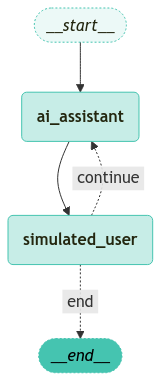

In [16]:
import random
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from dataclasses import dataclass


@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )


def visualize_graph(graph, xray=False):
    """
    CompiledStateGraph 객체를 시각화하여 표시합니다.

    이 함수는 주어진 그래프 객체가 CompiledStateGraph 인스턴스인 경우
    해당 그래프를 Mermaid 형식의 PNG 이미지로 변환하여 표시합니다.

    Args:
        graph: 시각화할 그래프 객체. CompiledStateGraph 인스턴스여야 합니다.

    Returns:
        None

    Raises:
        Exception: 그래프 시각화 과정에서 오류가 발생한 경우 예외를 출력합니다.
    """
    try:
        # 그래프 시각화
        if isinstance(graph, CompiledStateGraph):
            display(
                Image(
                    graph.get_graph(xray=xray).draw_mermaid_png(
                        background_color="white",
                        node_colors=NodeStyles(),
                    )
                )
            )
    except Exception as e:
        print(f"[ERROR] Visualize Graph Error: {e}")


def generate_random_hash():
    return f"{random.randint(0, 0xffffff):06x}"

visualize_graph(simulation)

### Start the Simulation

Now, you can evaluate the chatbot! You can call it with empty messages to simulate the chatbot initiating the conversation.

시뮬레이션에서 스트리밍되는 데이터 청크를 순회하며, 최종 종료 청크(`END`)를 제외한 모든 이벤트를 출력합니다. 

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# Configure (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# Define input messages
inputs = {
    "messages": [HumanMessage(content="Hello, I'm really upset right now.")]
}

# Stream the graph
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])

ModuleNotFoundError: No module named 'langchain_teddynote'